# Sentiment Analysis

In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
tqdm.pandas()

init_notebook_mode(connected=True)

Device: cuda


### Dataset preparation

In [ ]:
from datasets import load_dataset
from openai import OpenAI

llm = OpenAI(
           base_url = "https://api.endpoints.anyscale.com/v1",
           api_key=os.environ['ANYSCALE_API_KEY'],
        )

In [ ]:
imdb = load_dataset('stanfordnlp/imdb')

In [ ]:
import re
import json

def summarize(prompt, max_new_tokens=256):
    try:
        response = llm.chat.completions.create(
                    model = "meta-llama/Meta-Llama-3-70B-Instruct",
                    messages = [
                            {'role': 'user', 'content': f"Rewrite the following text in one sentence. Output only a single json file with a single field 'new_text'.\n{prompt}"},
                        ],
                    temperature=1,
                    max_tokens=max_new_tokens,
                )
                
        out = response.choices[0].message.content

        json_pattern = r"{.*?}"

        # Find all occurrences of JSON in the text
        match = re.findall(json_pattern, out)[0]
        json_data = json.loads(match)
        new_text = json_data["new_text"]

        return new_text
    except Exception as e:
        return out

In [ ]:
df = pd.DataFrame(imdb['train']).groupby('label').sample(250, random_state=42)
df['summary'] = df['text'].progress_apply(summarize)

### Data and model loading

In [2]:
df = pd.read_csv("imdb.csv")

train = pd.concat([
    df.iloc[:100],
    df.iloc[250:350],
], axis=0)

val = pd.concat([
    df.iloc[100:150],
    df.iloc[350:400],
], axis=0)

test = pd.concat([
    df.iloc[150:250],
    df.iloc[400:500],
], axis=0)

len(train), len(val), len(test)

(200, 100, 200)

In [3]:
model = HookedTransformer.from_pretrained('gemma-2b')

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


### Baseline

In [4]:
n_shots = 2

shots = pd.concat([
    val.iloc[:n_shots//2],
    val.iloc[50:50+n_shots//2],
], axis=0)

len(train), len(shots)

(200, 2)

In [5]:
import random

map = {
    1: 'positive',
    0: 'negative'
}

def generate_prompt(x, shots):
    prompt = ""

    for i in random.sample(range(n_shots), n_shots):
        shot = shots.iloc[i]
        prompt += f"{shot['summary']} | {map[shot['label']]}\n\n"

    prompt += x + " |"
    return prompt

In [ ]:
tokens = [model.to_single_token(tok) for tok in [' positive', ' negative']]
preds = []
for i in tqdm(range(len(train))):
    x = test.iloc[i]
    prompt = generate_prompt(x['summary'], shots)
    
    with torch.no_grad():
        proba = model(model.to_tokens(prompt)).softmax(-1)

    preds.append(proba[0, -1, tokens].tolist())

preds = np.array(preds)
train['pred_positive'] = preds[:, 0]
train['pred_negative'] = preds[:, 1]

In [ ]:
train['pred'] = train.apply(lambda x: 1 if x['pred_positive'] > x['pred_negative'] else 0, axis=1)
train['correct'] = train['label'] == train['pred']

In [ ]:
train.groupby('label')['correct'].mean()

In [ ]:
results_df = pd.DataFrame({
    'shots': [2, 4, 6, 8, 10],
    'pos_score': [0.97, 0.96, 0.94, 0.94, 0.94],
    'neg_score': [0.93, 0.93, 0.97, 0.96, 0.94]
})

sns.lineplot(
    results_df.melt(id_vars='shots', var_name='score'),
    x='shots', y='value', hue='score'
)

## Attribution Pathcing 

In [7]:
def get_cache_fwd_and_bwd(tokens, ans_clean, ans_corr=None):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        logits = model(tokens)
        value = logits[:, -1, ans_clean]
        if ans_corr is not None:
            value -= logits[:, -1, ans_corr]
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

In [10]:
import einops

ans_tokens = [model.to_single_token(tok) for tok in [' negative', ' positive']]
attn_patches = []
mlp_patches = []

for i in tqdm(range(len(train))):
    x = test.iloc[i]
    
    y = x.label
    a_clean = ans_tokens[y]
    a_corr = ans_tokens[1 - y]
    
    prompt = generate_prompt(x['summary'], shots)

    #
    _, cache, grad_cache = get_cache_fwd_and_bwd(model.to_tokens(prompt), a_clean, a_corr)

    attn_act = cache.stack_head_results(-1)
    attn_grad_act = grad_cache.stack_head_results(-1)

    mlp_act = cache.stack_activation('mlp_out')
    mlp_grad_act = grad_cache.stack_activation('mlp_out')

    attn_patches.append(einops.reduce(
                attn_grad_act *  attn_act,
                "component batch pos d_model -> component pos",
                "sum",
        )[:, -1])

    mlp_patches.append(einops.reduce(
                mlp_grad_act *  mlp_act,
                "component batch pos d_model -> component pos",
                "sum",
        )[:, -1])

attn_patches = torch.stack(attn_patches).mean(0)
mlp_patches = torch.stack(mlp_patches).mean(0)

attn_patch = attn_patches.reshape(model.cfg.n_layers, -1).detach().cpu()
mlp_patch = mlp_patches.reshape(model.cfg.n_layers, -1).detach().cpu()

100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


In [12]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

xs = [f"L{l}" for l in range(model.cfg.n_layers)]
ys = [f"H{h}" for h in range(model.cfg.n_heads)]

# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Attention", "MLP"))

# First imshow plot
fig1 = px.imshow(attn_patch, zmin=-1, zmax=1, color_continuous_scale='RdBu')
fig1.update_layout(
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(xs))),
        ticktext=xs
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(ys))),
        ticktext=ys
    )
)

# Second imshow plot
fig2 = px.imshow(mlp_patch, zmin=-1, zmax=1, color_continuous_scale='RdBu')
fig2.update_layout(
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(xs))),
        ticktext=xs
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(ys))),
        ticktext=ys
    )
)


for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# Update layout
fig.update_layout(
    height=800,
    showlegend=False
)

fig.write_html('patch.html')

### Heads Boost

In [23]:
def head_modifier_hook(x, hook, lam):
    x = lam[None, None, :, None] * x # b pos head dim
    return x

def mlp_modifier_hook(x, hook, gam):
    x = gam[None, :, None] * x # b pos dim
    return x

In [24]:
start_layer = 6

In [26]:
ans_tokens = [model.to_single_token(tok) for tok in [' positive', ' negative']]
preds = []

for i in tqdm(range(len(train))):
    x = test.iloc[i]
    prompt = generate_prompt(x['summary'], shots)
    
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(prompt),
            fwd_hooks=[(
                        f"blocks.{l}.attn.hook_result",
                        partial(head_modifier_hook, lam=1+attn_patch[l - start_layer].to(device)),
                    ) for l in range(start_layer, model.cfg.n_layers)] + 
                    [(
                        f"blocks.{l}.hook_mlp_out",
                        partial(mlp_modifier_hook, gam=1+mlp_patch[l - start_layer].to(device)),
                    ) for l in range(start_layer, model.cfg.n_layers)]
        ).softmax(-1)

    preds.append(proba[0, -1, ans_tokens].tolist())

preds = np.array(preds)
train['pred_positive'] = preds[:, 0]
train['pred_negative'] = preds[:, 1]

100%|██████████| 200/200 [00:26<00:00,  7.52it/s]


In [27]:
train['pred'] = train.apply(lambda x: 1 if x['pred_positive'] > x['pred_negative'] else 0, axis=1)
train['correct'] = train['label'] == train['pred']

In [28]:
train.groupby('label')['correct'].mean()

label
0    0.96
1    0.97
Name: correct, dtype: float64

### Testing

In [36]:
raw_scores = []
boost_scores = []

for n_shots in (2,4,6,8):

    shots = pd.concat([
        val.iloc[:n_shots//2],
        val.iloc[50:50+n_shots//2],
    ], axis=0)

    ans_tokens = [model.to_single_token(tok) for tok in [' positive', ' negative']]
    raw_preds = []
    boost_preds = []
    
    for i in tqdm(range(len(test))):
        x = test.iloc[i]
        prompt = generate_prompt(x['summary'], shots)
    
        # Raw preds
        with torch.no_grad():
            proba = model(model.to_tokens(prompt)).softmax(-1)
    
        raw_preds.append(proba[0, -1, tokens].tolist())
    
        # Boost preds
        proba = model.run_with_hooks(
                    model.to_tokens(prompt),
                    fwd_hooks=[(
                                f"blocks.{l}.attn.hook_result",
                                partial(head_modifier_hook, lam=1+attn_patch[l - start_layer].to(device)),
                            ) for l in range(start_layer, model.cfg.n_layers)] + 
                            [(
                                f"blocks.{l}.hook_mlp_out",
                                partial(mlp_modifier_hook, gam=1+mlp_patch[l - start_layer].to(device)),
                            ) for l in range(start_layer, model.cfg.n_layers)]
                ).softmax(-1)
        
        boost_preds.append(proba[0, -1, ans_tokens].tolist())
    
    raw_preds = np.array(raw_preds)
    boost_preds = np.array(boost_preds)
    test['raw_pred_positive'] = raw_preds[:, 0]
    test['raw_pred_negative'] = raw_preds[:, 1]
    
    boost_preds = np.array(boost_preds)
    boost_preds = np.array(boost_preds)
    test['boost_pred_positive'] = boost_preds[:, 0]
    test['boost_pred_negative'] = boost_preds[:, 1]

    test['raw_pred'] = test.apply(lambda x: 1 if x['raw_pred_positive'] > x['raw_pred_negative'] else 0, axis=1)
    test['boost_pred'] = test.apply(lambda x: 1 if x['boost_pred_positive'] > x['boost_pred_negative'] else 0, axis=1)
    
    test['raw_correct'] = test['label'] == test['raw_pred']
    test['boost_correct'] = test['label'] == test['boost_pred']

    raw_scores.append(test.groupby('label')['raw_correct'].mean().tolist())
    boost_scores.append(test.groupby('label')['boost_correct'].mean().tolist())

100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


In [37]:
raw_scores, boost_scores

([[0.94, 0.97], [0.96, 0.94], [0.97, 0.92], [0.95, 0.96]],
 [[0.96, 0.95], [0.97, 0.92], [0.97, 0.89], [0.97, 0.94]])

## SAEs

In [35]:
from huggingface_hub import snapshot_download

REPO_ID = "jbloom/GPT2-Small-SAEs-Reformatted"
path = snapshot_download(repo_id=REPO_ID)

Fetching 41 files:   0%|          | 0/41 [00:00<?, ?it/s]

In [36]:
from sae_lens import LMSparseAutoencoderSessionloader
from tqdm import tqdm
import os

layer = 13
_, sae_group, activation_store = LMSparseAutoencoderSessionloader.load_pretrained_sae(
    path = os.path.join(path, f"blocks.{layer}.hook_resid_pre"), device=device
)
sae_group.eval()
sae = sae_group[f'blocks.{layer}.hook_resid_pre']

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning:

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.

  8%|▊         | 1/12 [00:12<02:15, 12.29s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 17%|█▋        | 2/12 [00:22<01:50, 11.05s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 25%|██▌       | 3/12 [00:28<01:20,  8.96s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 33%|███▎      | 4/12 [00:35<01:03,  7.88s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 42%|████▏     | 5/12 [00:40<00:48,  6.93s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 50%|█████     | 6/12 [00:50<00:48,  8.02s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 58%|█████▊    | 7/12 [00:57<00:38,  7.77s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 67%|██████▋   | 8/12 [01:03<00:28,  7.24s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 75%|███████▌  | 9/12 [01:09<00:20,  6.80s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 83%|████████▎ | 10/12 [01:25<00:18,  9.43s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 92%|█████████▏| 11/12 [01:39<00:10, 10.96s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


100%|██████████| 12/12 [01:45<00:00,  8.82s/it]


In [39]:
from fancy_einsum import einsum
sae_cache = {}
sae_grad_cache = {}

def feature_edit_hook(x, hook, sae, f_id, pos, lam=2):
    sae_out, f_act, *_ = sae(x)
    f_act[:, pos, f_id] = f_act[:, pos, f_id] * lam
    edit = einsum(
        'b p dsae, dsae dm -> b p dm',
        f_act, sae.W_dec
    ) + sae.b_dec

def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    
    # Function to capture the gradient
    def capture_grad(grad):
        sae_grad_cache[hook.name] = grad.clone()

    # Register the hook to capture the gradient
    if f_act.requires_grad:
        f_act.register_hook(capture_grad)
    
    sae_cache[hook.name] = f_act.detach()
    return sae_out

In [59]:
def feature_editing(model, prompt, tokens):
    
    tokens = [model.to_single_token(tok) for tok in tokens]

    with torch.no_grad():
        proba = model(model.to_tokens(clean_prompt)).softmax(-1)
    
    vals = proba[..., tokens]
    return vals[0, -1, :].cpu().numpy().tolist()

In [98]:
# Feature Editing
tokens = [model.to_single_token(tok) for tok in ['John', 'Susan']]

#features = [(10, 13299)] 
pos = 113

hook_point = f'blocks.{layer_id}.hook_resid_pre'

token_probas = []

lams = np.linspace(-5, 5, 20)

for lam in tqdm(lams):



    
    with model.hooks(
        fwd_hooks=[
            (
                hook_point,
                partial(feature_edit_hook, sae=saes[layer_id], f_id=f_id, pos=pos, lam=lam),
            ) for layer_id, f_id in features
        ]
    ): token_probas.append(feature_editing(model, prompt, ['Susan', 'John']))

100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


In [100]:
token_probas

[[0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795]]

In [76]:
from functools import partial

component = 'resid_pre'

out = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    utils.get_act_name(component, layer_id),
                    partial(reconstr_hook, sae=saes[layer_id]),
                )
            for layer_id in range(model.cfg.n_layers)]
        ).log_softmax(-1)

ans = model.to_single_token('Susan')
loss = - out[0, -1, ans]

loss.backward()

In [77]:
act = torch.stack(list(sae_cache.values()))
grad_act = torch.stack(list(sae_grad_cache.values()))

patch = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos d_model",
                "sum",
            )

In [102]:
patch[:, 113].topk(3, -1).indices

tensor([[19419,  2670,  1318],
        [14858,     1,     0],
        [13070, 13411, 19241],
        [ 8524,  1294, 17696],
        [10433,     1,     0],
        [ 6677, 18816, 13863],
        [14243, 22334, 23861],
        [15585,  2650,  2028],
        [21490, 22557, 18215],
        [17803, 16510, 22344],
        [15266,  3565, 16895],
        [ 2665, 23640, 17467]], device='cuda:0')

In [65]:
p1_act = act[:, 0, 113]
p2_act = act[:, 0, 118]
delta_act = p2_act - p1_act

In [97]:
features = []
for l, fs in zip(range(12), patch[:, 113].topk(3, -1).indices.tolist()):
    for f in fs:
        features.append((l, f))

features

[(0, 19419),
 (0, 2670),
 (0, 1318),
 (1, 14858),
 (1, 1),
 (1, 0),
 (2, 13070),
 (2, 13411),
 (2, 19241),
 (3, 8524),
 (3, 1294),
 (3, 17696),
 (4, 10433),
 (4, 1),
 (4, 0),
 (5, 6677),
 (5, 18816),
 (5, 13863),
 (6, 14243),
 (6, 22334),
 (6, 23861),
 (7, 15585),
 (7, 2650),
 (7, 2028),
 (8, 21490),
 (8, 22557),
 (8, 18215),
 (9, 17803),
 (9, 16510),
 (9, 22344),
 (10, 15266),
 (10, 3565),
 (10, 16895),
 (11, 2665),
 (11, 23640),
 (11, 17467)]

In [48]:
vals, idxs = patch.mean(1).topk(5, dim=-1)

In [55]:
act.shape

torch.Size([12, 1, 151, 24576])

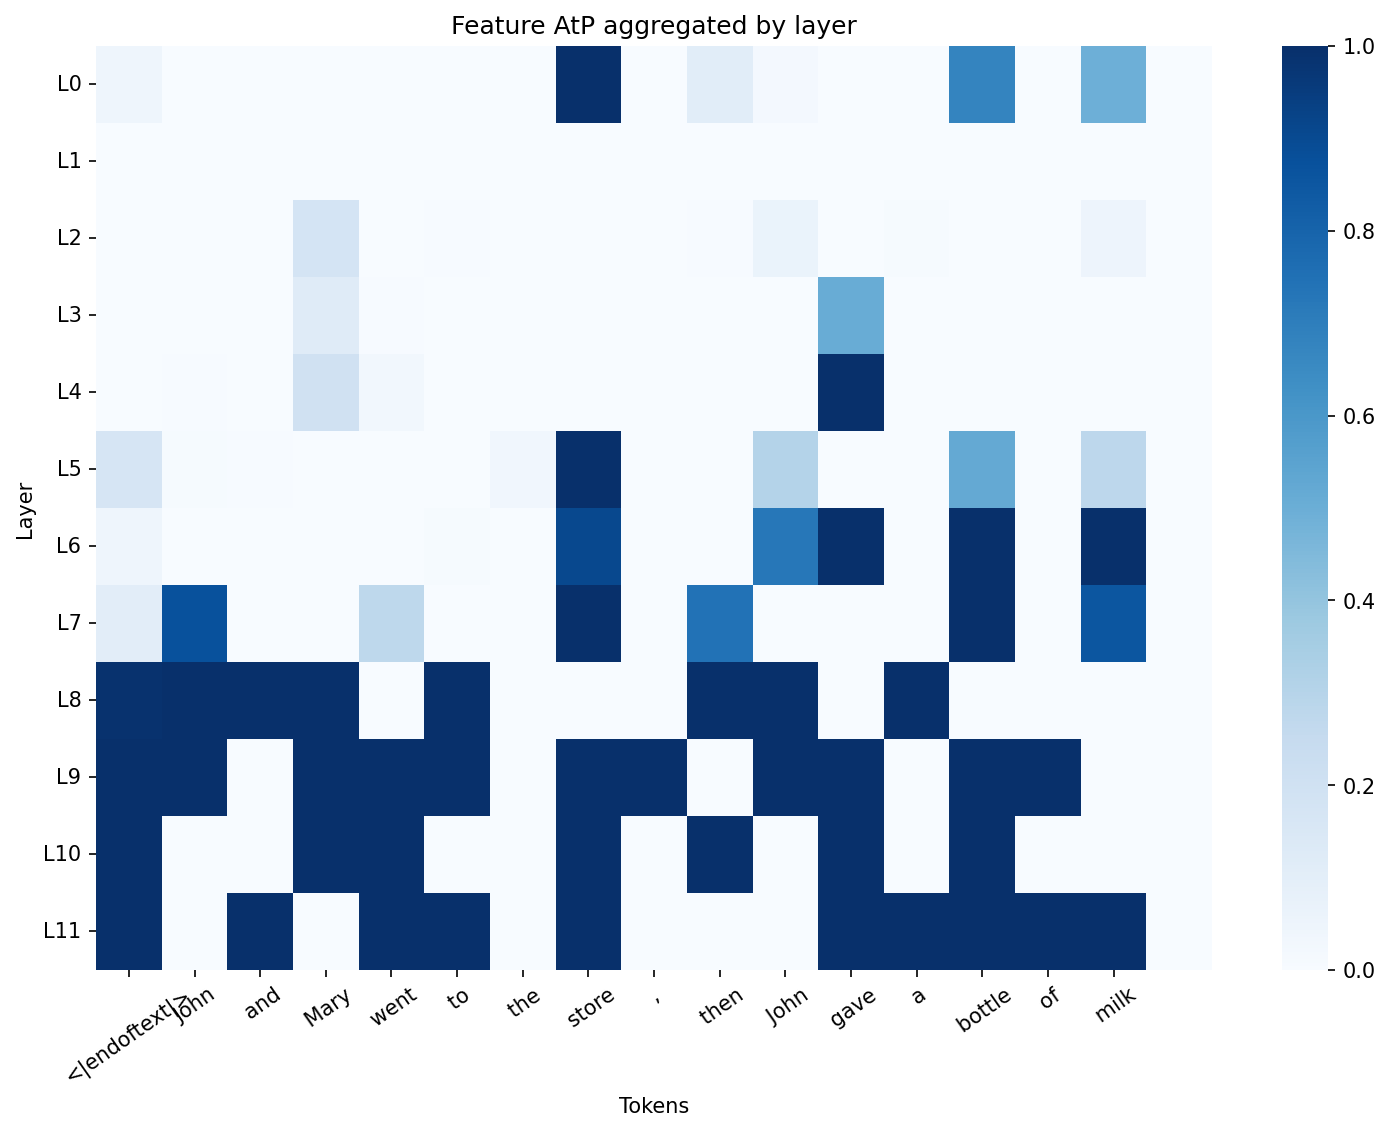

In [153]:
plt.figure(figsize=(12, 8), dpi=150)

ys = [f"L{i}" for i in range(model.cfg.n_layers)]

# Draw the heatmap
ax = sns.heatmap(patch.cpu().sum(-1), cmap='Blues', vmin=0, vmax=1)

# Set tick labels
ax.set_xticks([i + 0.5 for i in range(len(labels))])  # Set x-ticks every 10 columns
ax.set_yticks([i + 0.5 for i in range(len(ys))])  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels(labels)
ax.set_yticklabels(ys)

# Rotate tick labels for better visibility
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title('Feature AtP aggregated by layer')
plt.xlabel('Tokens')
plt.ylabel('Layer')

# Show the plot
plt.show()